# Balancer AMM Simulations

# Pool Exploration

This is a model and set of simulations to analyse a Balancer AMM pool, using **historical on-chain data**.

You'll be able to analyse: 
- C1 **Pool Power** (TVL, Absolute Growth, Liquidity, Balances)  
- C2 **Pool Characteristics** (Action Types, Weights, Token Power)

For more information on the Balancer AMM cadCAD model, checkout the [Balancer Simulations documentation](xxxadd link).

## Table of content
here List and links to content (automatically?)

# A. System Context

### System Specification
- Differential Syntax Diagram
- Link to Mathematical Specification
- Link to Software Archtitecture

### Naming Convention

All code provided for this package is following a specific naming convention. You'll find and overview in the documentation. (xxx add link)


### State Variables  


In [ ]:
from pprint import pprint as pp
from model.genesis_states import initial_values
pp(initial_values)

### Parameters

In [ ]:
from decimal import Decimal
parameters = {
    'spot_price_reference': ['DAI']
}
pp(parameters)

# B. cadCAD Notebook

### B1.0 Dependencies
- check dependencies, and link "requirements.txt" 

In [ ]:
import pandas as pd 
from cadCAD.configuration.utils import config_sim

# C. Run Simulations 

### C1.0 Initialize Pools


Pull initial balances from data: (how to data parse in readme.file in data folder)

In [ ]:
import pprint
from model.genesis_states import initial_values
pp = pprint.PrettyPrinter(indent=4)

print('## State Variables')
print('# Pool')
gen_values = initial_values
pool = gen_values['pool']
pp.pprint(pool)
print('# External token values feeds')
token_prices = gen_values['token_prices']
pp.pprint(token_prices)

print('# Action Type')
action_type = gen_values['action_type']
pp.pprint(action_type)


### C1.1 State Update Functions & Policies
The available state update functions replicate the following Balancer Pool Transactions:

a) Add Liquidity
= join policy 
- `p_join_pool`
- `p_join_swap_extern_amount_in`

b) Withdraw Liquidity
= exit policy 
- `p_exit_swap_extern_amount_out`

b) Swap
= swap policy 
- `p_swap_exact_amount_in`

See 'system_policies.py'.  
For a detailed description of the transactions, please visit (Gitbook link)

### C1.2 Partial State Update Blocks


1. Parse action and update pool
2. Update external prices
3. Calculate metrics

The BPool smart contract logic is split in 2, the state update blocks 1 (apply BMath to update pool state) and 3 (use BMath to `get_spot_price` of the tokens after the trades, which is a system metric)



Defined in [partial_state_update_block.py](./model/partial_state_update_block.py)

In [ ]:
from model.partial_state_update_block import generate_partial_state_update_blocks

result = generate_partial_state_update_blocks('model/parts/actions_prices-WETH-DAI-0x8b6e6e7b5b3801fed2cafd4b22b8a16c2f2db21a.json')
partial_state_update_blocks = result['partial_state_update_blocks']
pp.pprint(partial_state_update_blocks)

### C1.3 Configuration




In [ ]:
steps_number = result['steps_number']
print('# Steps ', steps_number)
sim_config = config_sim(
    {
        'N': 1,  # number of monte carlo runs
        'T': range(steps_number - 1),  # number of timesteps - 1267203 is last action timestep (timestamp - initial timestamp)
        'M': parameters,  # simulation parameters
    }
)

### C1.4 Execution

In [ ]:
from model.genesis_states import initial_values

from model.sim_runner import *

df = run(initial_values, partial_state_update_blocks, sim_config)


### C1.5 Simulation Output Preparation

In [ ]:
from model.parts.utils import post_processing

p_df = post_processing(df)
p_df

## D Results

### Sanity Check

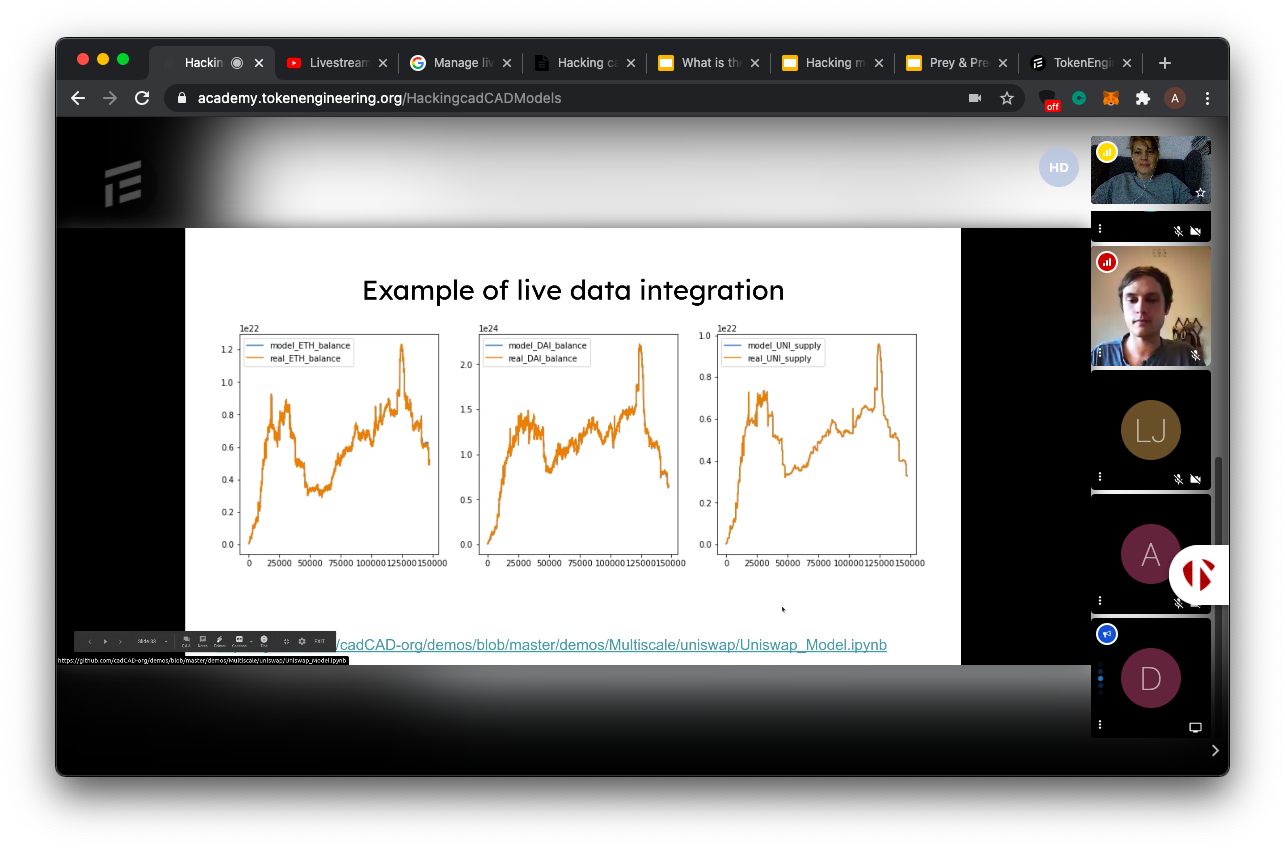

## D1 Pool Power

- the "power" of pools is associated with liquidity, and token value locked
- however, to understand the power of a pool you need to differentiate
a) USD value of tokens in the pool
b) absolute growth/decline of tokens in the pool
c) the pool share supply (reflecting the trust of liquidity providers in the pool)
d) the fees adding to absolute growth/decline (reflecting the attractivity for traders/arbitrage)

### D1.1 Missing: TVL (see issue #45)

In [ ]:
#Show TVL over time

### Absolute Pool Growth

In [ ]:
#Show sum of all tokens (exclude BPT)

### Pool Share Supply

In [ ]:
pd.options.plotting.backend = "plotly"

#Show pool_shares (in circulation)
p_df.plot(kind='line', x='timestep', y=['pool_shares'], height = 300, color_discrete_sequence=['#5CB1EC'],)

In [ ]:
#print value of 1 BPT in USD (calculate based on token_k_balances*price), issue #
#plot value of 1 BPT in USD (over time)

### Missing: fees collected (to show growth of balances due to swap fees)

### Token Balances

In [ ]:
# normalize the values, to show growth/decline only
# ratio of tokens
# add line to show tendency

In [ ]:
import plotly.express as px

fig1 = px.line(p_df, x='timestep', y='token_weth_balance',height=200, color_discrete_sequence=['#3C7E6F'])
fig2 = px.line(p_df, x='timestep', y='token_dai_balance',height=200, color_discrete_sequence=['#5CB1EC'])
fig1.show()
fig2.show()

## D2 Pool Characteristics

### Pool Actions

- actions counts
- actions over time (based on 1 token balance)

In [ ]:
#SHOW ACTION TYPES
# different color for price updates (grey)

import plotly.express as px
fig = px.histogram(p_df, x="action_type", height=300)

fig.show()

In [ ]:
#SHOW ACTION TYPE / BALANCE MOVEMENT (use total_balance or TVL as y axis)
fig = px.scatter(p_df, x='timestep', y='token_weth_balance', color='action_type')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

### Token Weights & Power

- show distribution of weight
- compare with power (according to token_k_balance or token_k_value

In [ ]:
#TOKEN WEIGHTS (for pools with >)
#Refactor: prepare pandas to show weights correctly!

import plotly.express as px
import pandas as pd

fig = px.line_polar(r=[10,30,60], theta=['token_a_weight','token_weth_b_weight','token_c_weight'], line_close=True)
fig.show()

# E. System Validation and Limitations

- move to Gitbook!
- document the steps taken to validate if the model reflects real Balancer AMM properly (Did we build the right model?)
- document the steps taken to verify if the model creates reliable results (Did we build the model right?)

### Notes (Draft!)
**a) BMath Calculations:**  
Our goal is to implement the BMath calculations in this Python model in a way that it replicates *exactly* the calculation results in an EVM.

We've verified the model with a series of tests:
- create tests using balancer's smart contract repos
- generate a pool contract in a local EVM, do a swap or whatever operation, 
- put those input outputs as a test in python, port the code, test to see if the results match

**b) external USD price feed** 
- in this simulation we're using historical USD prices from xxx (source)  
- to map blocks and transactions we've ... (how we parsed USD price feed)

**c) Our simulation does not include:**  
- gas prices or add_fees when adding liquidity  
- 

**Results: (summarize)**

(Notes for ourselves:
- assertAlmostEqual takes 7 decimal places for comparision, sometimes we had to set 5 decimal places for the test to pass
- we could publish the EVM tests  as companion in the docs later but right now is very rough code
- to run the test go to your virtual env, instlal requirements with pip, then run pytest
- they should pass
- when everything is tested and works as the contracts, we could move on to cadCAD stuff

According to Balancer.finance documentation "The formulas are sufficient to describe the functional specification, but they are not straightforward to implement for the EVM, in part due to a lack of mature fixed-point math libraries." (https://docs.balancer.finance/core-concepts/protocol/index))

# F. Comments

closing comments if appropriate, and links to other notebooks/other use cases